# BCG - PowerCo customer churn problem : Forage Project

## Background
This [challenge](https://www.theforage.com/virtual-internships/prototype/Tcz8gTtprzAS4xSoK/Data-Science-?ref=D7dEe4AjnkT7G8uPb) is about predicting the cutomers churn of one of BCG's clients called PowerCo. PowerCo is a leader, specializing in gas and electricity distribution to residential neighburhoods and SMEs. Due to liberalization policies in the power sector, many companies are being forced to reduce their long-run average costs in order to remain competitive in the market. They want a new, viable and effective pricing stategy to combat customer churn. PowerCo wants to explore the possibility of a 20% discounted rate preventing customer churn and have commissioned BCG to test this hypothesis. They also want us to define and assess customer's price sensitivity. 

## TASK 1: Business Understanding & Hypothesis Framing
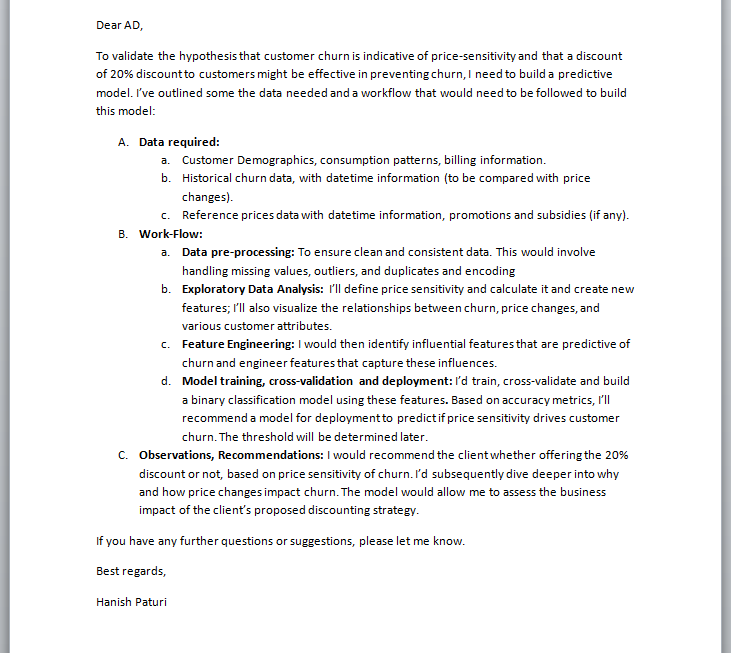

## TASK 2: Exploratory Data Analysis

We have been given the following sub-tasks to carry-out.

### Sub-Task 1:

Perform some exploratory data analysis. Look into the data types, data statistics, specific parameters, and variable distributions. This first subtask is for you to gain a holistic understanding of the dataset. You should spend around 1 hour on this.

### Sub-Task 2:

Verify the hypothesis of price sensitivity being to some extent correlated with churn. It is up to you to define price sensitivity and calculate it. You should spend around 30 minutes on this.


### Sub-Task 3:

Prepare a half-page summary or slide of key findings and add some suggestions for data augmentation – which other sources of data should the client provide you with and which open source datasets might be useful? You should spend 10-15 minutes on this.

For your final deliverable, please submit your analysis (in the form of a jupyter notebook, code script or PDF) as well as your half-page summary document.

**Note:** Use the 2 datasets within the additional resources for this task and if you’re unsure on where to start with visualizing data, use the accompanying links. Be sure to also use the data description document to understand what the columns represent. The task description document outlines the higher-level motivation of the project. Finally, use the eda_starter.ipynb file to get started with some helper functions and methods.

If you are stuck: Think about ways you can define price sensitivity. Make sure to think of all possible ways and investigate them.

Estimated time for task completion: 1.75 hours depending on your learning style.

## TASK 2 Outline: EDA

### Sub-task 1: 
1. Exploratory Data Analysis, to look for important features, trends and patterns, and to to analyze missing values, outliers, etc
2. Check and identify whether the churn happened  with a price increase 3 months prior.

### Sub-task 2:
1. We will define price sensitivity of churn at a given reference price as the % of customers churned within 3 months of a positive change in prices. Soft churn (if present) will be considered as hard churn. We will look into other definitions of price sensiivity at a later stage after exploring the raw data.

2. We will test the null hypothesis that customer churn is sensitive to price increase. The alternate hypohesis being that customer churn is insensitive to price increae. We will check this for a 95% confidence interval (of all churn observations).


### Sub-task 3:
Report write-up with summary findings and suggestions for data augmentation.

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime, scipy
from scipy.stats import skew

import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from IPython.display import display

%matplotlib inline
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline


# Set plot style
sns.set(color_codes=True)

## Loading data with Pandas

We need to load `client_data.csv` and `price_data.csv` into individual dataframes so that we can work with them in Python. For this notebook and all further notebooks, it will be assumed that the CSV files will the placed in the same file location as the notebook. If they are not, please adjust the directory within the `read_csv` method accordingly.

In [87]:
client = pd.read_csv('/kaggle/input/bcg-intership-files/client_data.csv')
price = pd.read_csv('/kaggle/input/bcg-intership-files/price_data.csv')

client_data.csv

●	id = client company identifier

●	activity_new = category of the company’s activity

●	channel_sales = code of the sales channel

●	cons_12m = electricity consumption of the past 12 months

●	cons_gas_12m = gas consumption of the past 12 months

●	cons_last_month = electricity consumption of the last month

●	date_activ = date of activation of the contract

●	date_end = registered date of the end of the contract

●	date_modif_prod = date of the last modification of the product

●	date_renewal = date of the next contract renewal

●	forecast_cons_12m = forecasted electricity consumption for next 12 months

●	forecast_cons_year = forecasted electricity consumption for the next calendar year

●	forecast_discount_energy = forecasted value of current discount

●	forecast_meter_rent_12m = forecasted bill of meter rental for the next 12 months

●	forecast_price_energy_off_peak = forecasted energy price for 1st period (off peak)

●	forecast_price_energy_peak = forecasted energy price for 2nd period (peak)

●	forecast_price_pow_off_peak = forecasted power price for 1st period (off peak)

●	has_gas = indicated if client is also a gas client

●	imp_cons = current paid consumption

●	margin_gross_pow_ele = gross margin on power subscription

●	margin_net_pow_ele = net margin on power subscription

●	nb_prod_act = number of active products and services

●	net_margin = total net margin

●	num_years_antig = antiquity of the client (in number of years)

●	origin_up = code of the electricity campaign the customer first subscribed to

●	pow_max = subscribed power

●	churn = has the client churned over the next 3 months


Note: some fields are hashed text strings. This preserves the privacy of the original data but the commercial meaning is retained and so they may have predictive power


price_data.csv

●	id = client company identifier

●	price_date = reference date

●	price_off_peak_var = price of energy for the 1st period (off peak)

●	price_peak_var = price of energy for the 2nd period (peak)

●	price_mid_peak_var = price of energy for the 3rd period (mid peak)

●	price_off_peak_fix = price of power for the 1st period (off peak)

●	price_peak_fix = price of power for the 2nd period (peak)

●	price_mid_peak_fix = price of power for the 3rd period (mid peak)

# Sub-task 1: EDA


In [88]:
price

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151,0.000,0.000,44.267,0.000,0.000
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151,0.000,0.000,44.267,0.000,0.000
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151,0.000,0.000,44.267,0.000,0.000
3,038af19179925da21a25619c5a24b745,2015-04-01,0.150,0.000,0.000,44.267,0.000,0.000
4,038af19179925da21a25619c5a24b745,2015-05-01,0.150,0.000,0.000,44.267,0.000,0.000
...,...,...,...,...,...,...,...,...
192997,16f51cdc2baa19af0b940ee1b3dd17d5,2015-08-01,0.120,0.102,0.076,40.729,24.437,16.292
192998,16f51cdc2baa19af0b940ee1b3dd17d5,2015-09-01,0.120,0.102,0.076,40.729,24.437,16.292
192999,16f51cdc2baa19af0b940ee1b3dd17d5,2015-10-01,0.120,0.102,0.076,40.729,24.437,16.292
193000,16f51cdc2baa19af0b940ee1b3dd17d5,2015-11-01,0.120,0.102,0.076,40.729,24.437,16.292


In [89]:
price['monthly_bill'] = price.iloc[:,2:].sum(axis=1)

In [105]:
client.iloc[0]

id                                24011ae4ebbe3035111d65fa7c15bc57
channel_sales                     foosdfpfkusacimwkcsosbicdxkicaua
cons_12m                                                         0
cons_gas_12m                                                 54946
cons_last_month                                                  0
date_activ                                     2013-06-15 00:00:00
date_end                                       2016-06-15 00:00:00
date_modif_prod                                2015-11-01 00:00:00
date_renewal                                   2015-06-23 00:00:00
forecast_cons_12m                                            0.000
forecast_cons_year                                               0
forecast_discount_energy                                     0.000
forecast_meter_rent_12m                                      1.780
forecast_price_energy_off_peak                               0.114
forecast_price_energy_peak                                   0

In [91]:
client.info(), price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

(None, None)

In [92]:
client.describe(include='all', datetime_is_numeric=True)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
count,14606,14606,14606.000,14606.000,14606.000,14606,14606,14606,14606,14606.000,14606.000,14606.000,14606.000,14606.000,14606.000,14606.000,14606,14606.000,14606.000,14606.000,14606.000,14606.000,14606.000,14606,14606.000,14606.000
unique,14606,8,NaN,NaN,NaN,1796,368,2129,386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN
top,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,NaN,NaN,NaN,2009-08-01,2016-02-01,2015-11-01,2015-06-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN,lxidpiddsbxsbosboudacockeimpuepw,NaN,NaN
freq,1,6754,NaN,NaN,NaN,95,145,721,587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11955,NaN,NaN,NaN,NaN,NaN,NaN,7097,NaN,NaN
mean,NaN,NaN,159220.286,28092.375,16090.270,NaN,NaN,NaN,NaN,1868.615,1399.763,0.967,63.087,0.137,0.050,43.130,NaN,152.787,24.565,24.563,1.292,189.265,4.998,NaN,18.135,0.097
std,NaN,NaN,573465.264,162973.059,64364.196,NaN,NaN,NaN,NaN,2387.572,3247.786,5.108,66.166,0.025,0.049,4.486,NaN,341.369,20.231,20.230,0.710,311.798,1.612,NaN,13.535,0.296
min,NaN,NaN,0.000,0.000,0.000,NaN,NaN,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,0.000,0.000,0.000,1.000,0.000,1.000,NaN,3.300,0.000
25%,NaN,NaN,5674.750,0.000,0.000,NaN,NaN,NaN,NaN,494.995,0.000,0.000,16.180,0.116,0.000,40.607,NaN,0.000,14.280,14.280,1.000,50.712,4.000,NaN,12.500,0.000
50%,NaN,NaN,14115.500,0.000,792.500,NaN,NaN,NaN,NaN,1112.875,314.000,0.000,18.795,0.143,0.084,44.311,NaN,37.395,21.640,21.640,1.000,112.530,5.000,NaN,13.856,0.000
75%,NaN,NaN,40763.750,0.000,3383.000,NaN,NaN,NaN,NaN,2401.790,1745.750,0.000,131.030,0.146,0.099,44.311,NaN,193.980,29.880,29.880,1.000,243.097,6.000,NaN,19.172,0.000


In [93]:
price.describe(include='all', datetime_is_numeric=True)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,monthly_bill
count,193002,193002,193002.000,193002.000,193002.000,193002.000,193002.000,193002.000,193002.000
unique,16096,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,038af19179925da21a25619c5a24b745,2015-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,12,16094,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.141,0.055,0.030,43.334,10.623,6.410,60.593
std,NaN,NaN,0.025,0.050,0.036,5.410,12.842,7.774,20.517
min,NaN,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,NaN,NaN,0.126,0.000,0.000,40.729,0.000,0.000,44.419
50%,NaN,NaN,0.146,0.085,0.000,44.267,0.000,0.000,44.598
75%,NaN,NaN,0.152,0.102,0.073,44.445,24.340,16.226,81.444


There seems to be no null values. Let's explore further.

In [94]:
client.isna().sum(), price.isna().sum()

(id                                0
 channel_sales                     0
 cons_12m                          0
 cons_gas_12m                      0
 cons_last_month                   0
 date_activ                        0
 date_end                          0
 date_modif_prod                   0
 date_renewal                      0
 forecast_cons_12m                 0
 forecast_cons_year                0
 forecast_discount_energy          0
 forecast_meter_rent_12m           0
 forecast_price_energy_off_peak    0
 forecast_price_energy_peak        0
 forecast_price_pow_off_peak       0
 has_gas                           0
 imp_cons                          0
 margin_gross_pow_ele              0
 margin_net_pow_ele                0
 nb_prod_act                       0
 net_margin                        0
 num_years_antig                   0
 origin_up                         0
 pow_max                           0
 churn                             0
 dtype: int64,
 id                    

Lets first convert the object features with date data to datetime type.

In [95]:
## Lets first convert the object features with date data to datetime type
date_features =['date_activ','date_end','date_modif_prod', 'date_renewal']
for feature in date_features:
    client[feature] = pd.to_datetime(client[feature])
price['price_date'] = pd.to_datetime(price['price_date'])

In [96]:
client.dtypes

id                                        object
channel_sales                             object
cons_12m                                   int64
cons_gas_12m                               int64
cons_last_month                            int64
date_activ                        datetime64[ns]
date_end                          datetime64[ns]
date_modif_prod                   datetime64[ns]
date_renewal                      datetime64[ns]
forecast_cons_12m                        float64
forecast_cons_year                         int64
forecast_discount_energy                 float64
forecast_meter_rent_12m                  float64
forecast_price_energy_off_peak           float64
forecast_price_energy_peak               float64
forecast_price_pow_off_peak              float64
has_gas                                   object
imp_cons                                 float64
margin_gross_pow_ele                     float64
margin_net_pow_ele                       float64
nb_prod_act         

In [97]:
merged_data = pd.merge(client, price, on='id', how='inner')
merged_df = merged_data.copy()

In [98]:
merged_data['delta_price_dt_end_date'] = merged_data['date_end'] - merged_data['price_date']
    
## Lets add three new columns
merged_data['contract_start_year'] = merged_data['date_activ'].dt.year
merged_data['contract_end_year'] = merged_data['date_end'].dt.year
merged_data['period_subscribed'] = merged_data['contract_end_year']-merged_data['contract_start_year']

In [100]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175149 entries, 0 to 175148
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype          
---  ------                          --------------   -----          
 0   id                              175149 non-null  object         
 1   channel_sales                   175149 non-null  object         
 2   cons_12m                        175149 non-null  int64          
 3   cons_gas_12m                    175149 non-null  int64          
 4   cons_last_month                 175149 non-null  int64          
 5   date_activ                      175149 non-null  datetime64[ns] 
 6   date_end                        175149 non-null  datetime64[ns] 
 7   date_modif_prod                 175149 non-null  datetime64[ns] 
 8   date_renewal                    175149 non-null  datetime64[ns] 
 9   forecast_cons_12m               175149 non-null  float64        
 10  forecast_cons_year              175149 non-n

## These features - channel_sales , origin_up, has_gas are nominal. So we will encode them.

In [102]:
a, b = client.channel_sales.unique(), client.origin_up.unique()

replace_dict = {**{i:i[:5] for i in a},
                 **{i:i[:5] for i in b}}
replace_dict

{'foosdfpfkusacimwkcsosbicdxkicaua': 'foosd',
 'MISSING': 'MISSI',
 'lmkebamcaaclubfxadlmueccxoimlema': 'lmkeb',
 'usilxuppasemubllopkaafesmlibmsdf': 'usilx',
 'ewpakwlliwisiwduibdlfmalxowmwpci': 'ewpak',
 'epumfxlbckeskwekxbiuasklxalciiuu': 'epumf',
 'sddiedcslfslkckwlfkdpoeeailfpeds': 'sddie',
 'fixdbufsefwooaasfcxdxadsiekoceaa': 'fixdb',
 'lxidpiddsbxsbosboudacockeimpuepw': 'lxidp',
 'kamkkxfxxuwbdslkwifmmcsiusiuosws': 'kamkk',
 'ldkssxwpmemidmecebumciepifcamkci': 'ldkss',
 'usapbepcfoloekilkwsdiboslwaxobdp': 'usapb',
 'ewxeelcelemmiwuafmddpobolfuxioce': 'ewxee'}

In [66]:
merged_data = merged_data.replace(replace_dict)
merged_data = pd.get_dummies(merged_data, columns=['channel_sales' , 'origin_up'])

In [41]:
merged_data.has_gas

0         t
1         t
2         t
3         t
4         t
         ..
175144    f
175145    f
175146    f
175147    f
175148    f
Name: has_gas, Length: 175149, dtype: object

In [44]:
## label encoding 
has_gas_encoder = LabelEncoder()
merged_data['has_gas'] = has_gas_encoder.fit_transform(merged_data['has_gas']) #t=1, f=0

In [103]:
merged_data.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,monthly_bill,delta_price_dt_end_date,contract_start_year,contract_end_year,period_subscribed
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.000,0,0.000,1.780,0.114,0.098,40.607,t,0.000,25.440,25.440,2,678.990,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-01-01,0.126,0.103,0.072,40.566,24.340,16.226,81.433,531 days,2013,2016,3
1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.000,0,0.000,1.780,0.114,0.098,40.607,t,0.000,25.440,25.440,2,678.990,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-02-01,0.126,0.103,0.072,40.566,24.340,16.226,81.433,500 days,2013,2016,3
2,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.000,0,0.000,1.780,0.114,0.098,40.607,t,0.000,25.440,25.440,2,678.990,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,2015-03-01,0.126,0.103,0.072,40.566,24.340,16.226,81.433,472 days,2013,2016,3


In [48]:
merged_data.columns

Index(['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'date_activ',
       'date_end', 'date_modif_prod', 'date_renewal', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max', 'churn', 'price_date',
       'price_off_peak_var', 'price_peak_var', 'price_mid_peak_var',
       'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix',
       'total_price', 'price_dt_minus_end_date', 'contract_start_year',
       'contract_end_year', 'period_subscribed', 'channel_sales_MISSI',
       'channel_sales_epumf', 'channel_sales_ewpak', 'channel_sales_fixdb',
       'channel_sales_foosd', 'channel_sales_lmkeb', 'channel_sales_sddie',
       'channel_sales_usilx', 'origin_up_MISSI', 'origin_up

## **Price Sensitivity and Churn**
#### Now would be a good stage to define price sensitivity of customers. The price sensitivity is a measure of the customer's willingness to pay an additional unit of good/service at a certain price point. In other words, its a measure of change of customer's purchasing behaviour ata certain price.

#### Price Sensitivity is influenced by various factors:
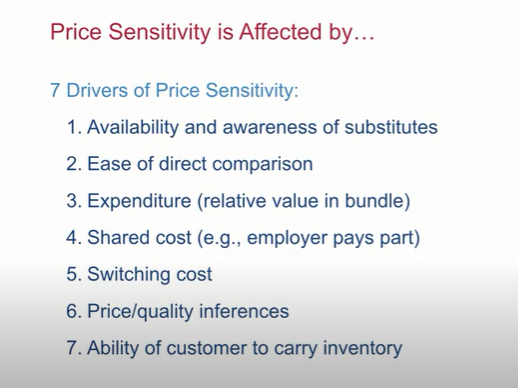

As the **Law of Diminishing Demand** states, the demand for a (normal) good decreases with increase in price. Here's an [article](https://www.investopedia.com/terms/p/priceelasticity.asp#:~:text=is%20quite%20elastic.-,What%20is%20price%20elasticity%20of%20demand%3F,when%20a%20product's%20price%20changes.) for better understanding. Demand curves are downward sloping in microeconomic models since each additional unit of a good or service is put toward a less valuable use.

**Inelastic demand** of a good/service implies there is **no significant % change in demand with change in price. And in this case, client does not churn.**

**Elastic demand** of a good/service implies there is **significant % change in demand with change in price. Here, the client churns.** The price threshold for churn is the price above which the customer churns.

One of our tasks in this step of the challenge would be to come up with definition for this price sensitivity for a client. We will deal with this later in this notebook.

We have our demand/consumption details in place. So let's test the validity of the Law of Demand for the utilities of gas and electricity supply. Price sensitivity/elasticity of demand is defined as **(change in demand/original demand)/(change in price/old price)**

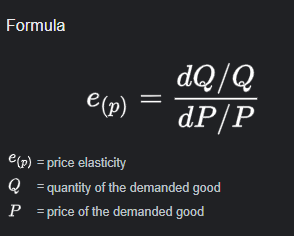

Demand curves are downward sloping in microeconomic models since each additional unit of a good or service is put toward a less valuable use.

In [ ]:
#merged_data['dQ_Q_cons_12m', 'dQ_Q_imp_cons']

In [108]:
['cons_12m', 'cons_gas_12m', 'cons_last_month',
'forecast_cons_12m', 'forecast_cons_year', 'imp_cons']

['id', 'channel_sales',
       'date_activ', 'date_end', 'date_modif_prod', 'date_renewal',
       'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn',
       'price_date', 'price_off_peak_var', 'price_peak_var',
       'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix',
       'price_mid_peak_fix', 'total_price']

['id',
 'channel_sales',
 'date_activ',
 'date_end',
 'date_modif_prod',
 'date_renewal',
 'forecast_discount_energy',
 'forecast_meter_rent_12m',
 'forecast_price_energy_off_peak',
 'forecast_price_energy_peak',
 'forecast_price_pow_off_peak',
 'has_gas',
 'margin_gross_pow_ele',
 'margin_net_pow_ele',
 'nb_prod_act',
 'net_margin',
 'num_years_antig',
 'origin_up',
 'pow_max',
 'churn',
 'price_date',
 'price_off_peak_var',
 'price_peak_var',
 'price_mid_peak_var',
 'price_off_peak_fix',
 'price_peak_fix',
 'price_mid_peak_fix',
 'total_price']

In [ ]:
id = 'id'
cons = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 
        'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy', 'pow_max']
dates = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal', 'contract_start_year', 'contract_end_year']       
forecast = ['forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak'], 
has_gas = 'has_gas',
churn = 'churn'
current_consumption = 'imp_cons' 
profit_margins = ['margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin'] 
num_products = 'nb_prod_act',
aging =[ 'num_years_antig', 'period_subscribed'] 
campaign = 'origin_up',
price_features = ['price_date', 'price_off_peak_var', 'price_peak_var',
       'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix',
       'price_mid_peak_fix', 'total_price']

In [110]:
merged_df = merged_df.groupby(by='id', group_keys=True)

In [124]:
merged_df.id.unique()

id
0002203ffbb812588b632b9e628cc38d    [0002203ffbb812588b632b9e628cc38d]
0004351ebdd665e6ee664792efc4fd13    [0004351ebdd665e6ee664792efc4fd13]
0010bcc39e42b3c2131ed2ce55246e3c    [0010bcc39e42b3c2131ed2ce55246e3c]
00114d74e963e47177db89bc70108537    [00114d74e963e47177db89bc70108537]
0013f326a839a2f6ad87a1859952d227    [0013f326a839a2f6ad87a1859952d227]
                                                   ...                
ffebf6a979dd0b17a41076df1057e733    [ffebf6a979dd0b17a41076df1057e733]
fffac626da707b1b5ab11e8431a4d0a2    [fffac626da707b1b5ab11e8431a4d0a2]
fffc0cacd305dd51f316424bbb08d1bd    [fffc0cacd305dd51f316424bbb08d1bd]
fffe4f5646aa39c7f97f95ae2679ce64    [fffe4f5646aa39c7f97f95ae2679ce64]
ffff7fa066f1fb305ae285bb03bf325a    [ffff7fa066f1fb305ae285bb03bf325a]
Name: id, Length: 14606, dtype: object

In [128]:
merged_df.id.unique()[i][0]

'0002203ffbb812588b632b9e628cc38d'

In [ ]:
for i in range(len(merged_df.id.unique())):
    merged_df.get_group(merged_df.id.unique()[i][0])

In [116]:
merged_df.get_group('0004351ebdd665e6ee664792efc4fd13')

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,monthly_bill
41331,0004351ebdd665e6ee664792efc4fd13,MISSING,4060,0,0,2009-08-06,2016-06-21,2013-06-21,2015-06-23,597.770,0,0.000,6.840,0.142,0.000,44.311,f,0.000,24.420,24.420,1,61.580,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,2015-01-01,0.148,0.000,0.000,44.267,0.000,0.000,44.415
41332,0004351ebdd665e6ee664792efc4fd13,MISSING,4060,0,0,2009-08-06,2016-06-21,2013-06-21,2015-06-23,597.770,0,0.000,6.840,0.142,0.000,44.311,f,0.000,24.420,24.420,1,61.580,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,2015-02-01,0.148,0.000,0.000,44.267,0.000,0.000,44.415
41333,0004351ebdd665e6ee664792efc4fd13,MISSING,4060,0,0,2009-08-06,2016-06-21,2013-06-21,2015-06-23,597.770,0,0.000,6.840,0.142,0.000,44.311,f,0.000,24.420,24.420,1,61.580,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,2015-03-01,0.148,0.000,0.000,44.267,0.000,0.000,44.415
41334,0004351ebdd665e6ee664792efc4fd13,MISSING,4060,0,0,2009-08-06,2016-06-21,2013-06-21,2015-06-23,597.770,0,0.000,6.840,0.142,0.000,44.311,f,0.000,24.420,24.420,1,61.580,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,2015-04-01,0.148,0.000,0.000,44.267,0.000,0.000,44.415
41335,0004351ebdd665e6ee664792efc4fd13,MISSING,4060,0,0,2009-08-06,2016-06-21,2013-06-21,2015-06-23,597.770,0,0.000,6.840,0.142,0.000,44.311,f,0.000,24.420,24.420,1,61.580,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,2015-05-01,0.148,0.000,0.000,44.445,0.000,0.000,44.593
41336,0004351ebdd665e6ee664792efc4fd13,MISSING,4060,0,0,2009-08-06,2016-06-21,2013-06-21,2015-06-23,597.770,0,0.000,6.840,0.142,0.000,44.311,f,0.000,24.420,24.420,1,61.580,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,2015-06-01,0.148,0.000,0.000,44.445,0.000,0.000,44.593
41337,0004351ebdd665e6ee664792efc4fd13,MISSING,4060,0,0,2009-08-06,2016-06-21,2013-06-21,2015-06-23,597.770,0,0.000,6.840,0.142,0.000,44.311,f,0.000,24.420,24.420,1,61.580,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,2015-07-01,0.148,0.000,0.000,44.445,0.000,0.000,44.593
41338,0004351ebdd665e6ee664792efc4fd13,MISSING,4060,0,0,2009-08-06,2016-06-21,2013-06-21,2015-06-23,597.770,0,0.000,6.840,0.142,0.000,44.311,f,0.000,24.420,24.420,1,61.580,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,2015-08-01,0.144,0.000,0.000,44.445,0.000,0.000,44.589
41339,0004351ebdd665e6ee664792efc4fd13,MISSING,4060,0,0,2009-08-06,2016-06-21,2013-06-21,2015-06-23,597.770,0,0.000,6.840,0.142,0.000,44.311,f,0.000,24.420,24.420,1,61.580,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,2015-09-01,0.144,0.000,0.000,44.445,0.000,0.000,44.589
41340,0004351ebdd665e6ee664792efc4fd13,MISSING,4060,0,0,2009-08-06,2016-06-21,2013-06-21,2015-06-23,597.770,0,0.000,6.840,0.142,0.000,44.311,f,0.000,24.420,24.420,1,61.580,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,2015-10-01,0.144,0.000,0.000,44.445,0.000,0.000,44.589


In [118]:
for id in merged_df.id.unique():
    merged_df.get_group(id)#.sort_values('price_date', ascending = True)

TypeError: unhashable type: 'numpy.ndarray'

I'll define a method to visualize the correlation matrix and use Spearman's rank-order correlation check for monotonicity between different features.

In [ ]:
def corr_map(df, title, method='spearman', numeric_only = True, tick_size = 16, annot_size=18):
    mask = np.triu(np.ones_like(df.corr(method=method,numeric_only=numeric_only), dtype=bool))
    heatmap = sns.heatmap(df.corr(method=method, numeric_only = numeric_only), annot = True, mask=mask, cmap='BrBG')#
    plt.xticks(rotation=80, fontsize= tick_size)
    plt.yticks( fontsize= tick_size)
    heatmap.set_title(title, fontdict={'fontsize':annot_size}, pad=12);

In [ ]:
plt.figure(figsize=(6, 4))
corr_map(price, 'price heatmap', 'spearman')

In [ ]:
plt.figure(figsize=(30, 14))
corr_map(client, 'client heatmap', 'spearman')

In [ ]:
plt.figure(figsize=(30, 20))
corr_map(merged_df, 'merged_df heatmap', 'spearman', annot_size=20)

### Key observations from the heatmaps:

1. forecast_cons_12m and imp_cons, the features describing **future and current demand are monotonic**, as expected.

2. The pairs, (forecast_cons_12m, cons_12m) (forecast_cons_12m, net_margin), and (cons_12m, net_margin) are strongly correlated, which means, the **current demand, future demand of electricity and profits are strongly pairwise-correlated**.

3. **Counterintuitivey, cons_12m is weakly correlated with the other forecast variables** like 'forecast_cons_year', 'forecast_discount_energy', 'forecast_meter_rent_12m','forecast_price_energy_off_peak','forecast_price_energy_peak', forecast_price_pow_off_peak'. Market research into competitors, changing privatized landscape of power distribution should be conducted to understand this inconsistency.

4. Most gas consumers also tend to use 2 products.

5. The forecasted price features are strongly correlated with each other and with the maximum power subscribed (pow_max). 

6. The forecasted price features also are strongly correlated with the pricing dataset features.

In [ ]:
sns.regplot(x=merged_df.forecast_meter_rent_12m,y=merged_df.forecast_price_energy_peak, x_jitter = 0.01);

Now let's define a function to explore categorical features

In [ ]:
def descr_cat_features(dataset):
    cat_columns = dataset.dtypes[dataset.dtypes=='O'].index.tolist()
    if len(cat_columns)!=0:
        print('Categorical variables are', cat_columns,'\n'+'=='*40)
        for cat in cat_columns:
            describe_frame = dataset[[cat]].value_counts().reset_index(name='count')
            describe_frame['proportion'] = describe_frame['count']/len(dataset)
            print(describe_frame,'\n'+'--'*40)    # display value count and proportion of a categorical feature
    else:
        print('There is no categorical variables in the dataset')
        
# dataset: a pandas dataframe;
def descr_num_features(dataset):
    # for numeric columns whose values are discrete, display values and their frequency
    int_columns = dataset.dtypes[dataset.dtypes=='int'].index.tolist()
    # for numeric columns whose values are continuous, plot their value distribution
    float_columns = dataset.dtypes[dataset.dtypes=='float'].index.tolist()
    if len(int_columns)+len(float_columns)!=0:
        print('Numeric variables are', int_columns+float_columns,'\n'+'=='*40)
        # integer numeric feature
        if len(int_columns)!=0:    
            for cat in int_columns:
                describe_frame = dataset[[cat]].value_counts().reset_index(name='count')
                describe_frame['proportion'] = describe_frame['count']/len(dataset)
                print(describe_frame,'\n'+'--'*40)    # display value count and proportion of a categorical feature
        # 
        print(dataset[int_columns + float_columns].describe().loc[['min','max','mean','50%']].T.rename(columns={'50%':'median'}), '\n'+'--'*40)
    else:
        print('There is no numeric variables in the dataset')

In [ ]:
descr_cat_features(merged_df), descr_num_features(merged_df)

Theres some interesting observations made from this.

1. Some MISSING values in categorical features.
2. Three categorial features, 'has_gas', 'channel_sales' and 'origin_up' are impossible to establish any ordinality in, so we'll encode them using LabelEncoder().
3. Almost all clients have consumed electricity in the last 12 months while less than 20% have consumed gas in the last 12 months.
4. Almost all clients have subscribed for a period of 3-7 years ('num_years_antig').
5. We will explore some more using visualizations.

In [ ]:
merged_df[merged_df.churn == 0].head(30)

In [ ]:
client.dtypes[client.dtypes=='datetime64[ns]'].index.tolist()

In [ ]:
client[client.dtypes[client.dtypes=='datetime64[ns]'].index.tolist()].describe(datetime_is_numeric=True)

In [ ]:
## lets look for discrete variables
client_counts = {i: client[i].nunique() for i in client.columns}
client_counts

Let's explore the price dataaset now

In [ ]:
client.info(), price.info() 

price_data.csv

●	id = client company identifier

●	price_date = reference date

●	price_off_peak_var = price of energy for the 1st period (off peak)

●	price_peak_var = price of energy for the 2nd period (peak)

●	price_mid_peak_var = price of energy for the 3rd period (mid peak)

●	price_off_peak_fix = price of power for the 1st period (off peak)

●	price_peak_fix = price of power for the 2nd period (peak)

●	price_mid_peak_fix = price of power for the 3rd period (mid peak)

In [ ]:
descr_num_features(price)

In [ ]:
price['price_date'].describe(datetime_is_numeric=True)

In [ ]:
#display duplicate rows
if price['id'].duplicated().sum()!=0:
    print('There are', price.duplicated().sum(), 'duplicate ids\n')
else:
    print('There is no duplicate ids\n')

#### Let's define some functions for visualizing the relationships between features and target


In [ ]:
# define a function to plot bar chart to display a feature's distribution with percent labels.
def plot_bar_chart_with_percent_label(df, target_variable, if_sort=False, gap_label_bar=0, figsize=(9,6)):
    # prepare data
    plot_data = client[[target_variable]].value_counts().reset_index(name='count')
    plot_data['percent'] = plot_data['count']/plot_data['count'].sum()
    if if_sort:
        x_order = plot_data.sort_values(by=['percent'], ascending=False)[target_variable]
    else:
        x_order = plot_data.sort_values(by=[target_variable], ascending=True)[target_variable]
    # plot
    fig = plt.figure(figsize=figsize)
    ax = sns.barplot(data=plot_data, x=target_variable, y='percent', order=x_order)
    plt.xticks(rotation =45)
    # add label
    for p in ax.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_height() + gap_label_bar
        ax.annotate(text='{:.2f}%'.format(p.get_height()*100), xy=(x, y), ha='center')
    ax.margins(y=0.1)

# plot stacked bar chart with percent label by churn
def plot_stacked_bar_with_percent_label_by_churn(df, target_variable, if_sort=False, figsize=(9,6)):
    if target_variable != 'churn':
        plot_data = df.groupby([target_variable,'churn']).size().reset_index(name='count')
        plot_data = plot_data.pivot(index=target_variable, columns='churn', values='count').fillna(0)
        plot_data = plot_data.div(plot_data.sum(axis=1), axis=0)
        if if_sort:
            plot_data = plot_data.sort_values(by=[0])
        ax = plot_data.plot(kind='bar', rot=False, stacked=True, figsize=figsize)
        plt.xticks(rotation=45)
        plt.legend(['stay', 'switch'], loc='upper center', ncol=2)
        # add label
        for p in ax.patches:
            percentage = '{:.1f}%'.format(p.get_height()*100)
            if percentage!='0.0%':
                x = p.get_x() + p.get_width()/2
                y = 1 - p.get_height()/1.8
                ax.annotate(text=percentage, xy=(x, y), ha='center')
        ax.margins(y=0.1)

In [ ]:
discrete_features={}
for i in [idx for (idx,values) in client_counts.items() if values<15]:
    discrete_features[i] = client[i].unique()
discrete_features

In [ ]:
for key, value in discrete_features.items():
    plot_bar_chart_with_percent_label(df=client, target_variable = key, if_sort=True)

In [ ]:
for key, value in discrete_features.items():
    plot_stacked_bar_with_percent_label_by_churn(df=client, target_variable=key, if_sort=False, figsize=(9,6))

In [ ]:
sns.pairplot(price);

In [ ]:
# create bins for the variable of interest
variable_of_interest = list(set(merged_data.columns)-set(discrete_features) - {'id'})
num_bins = 50

for i in variable_of_interest:
        
    # plot the frequency histogram
    fig, ax = plt.subplots()
    ax.hist(merged_data[i], bins=num_bins, density=True)
    ax.set_xlabel(i)
    ax.set_ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()
variable_of_interest

In [ ]:
for i in merged_data.columns:
    sns.catplot(x="churn", y="price_peak_fix", kind="box", data=merged_data)
    plt.ylabel('Price of power for the 1st period')
    plt.xticks([0,1],['No', 'Yes'])
    plt.title('Boxplot of power price for customers in the 1st period')

In [ ]:
cons = ['cons_12m', 'cons_gas_12m', 'cons_last_month','cons_last_month', 
        'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak']

cons_grouped_df_by_churn = client.groupby(['churn'])

for i in cons:
    print(i)
    sns.boxplot(x=client['churn', y = client[i])

In [ ]:
# Load the client_data.csv file
client_df = pd.read_csv('/kaggle/input/bcg-intership-files/client_data.csv')

# Load the price_data.csv file
price_df = pd.read_csv('/kaggle/input/bcg-intership-files/price_data.csv')


# Visualize the target variable (churn) in the client data
sns.countplot(x='churn', data=client_df)
plt.show()

# Visualize the distribution of electricity consumption in the past 12 months
sns.histplot(x='cons_12m', data=client_df)
plt.show()

# Visualize the relationship between net margin and electricity consumption
sns.scatterplot(x='cons_12m', y='net_margin', data=client_df)
plt.show()

# Visualize the relationship between churn and number of active products and services
sns.boxplot(x='churn', y='nb_prod_act', data=client_df)
plt.show()

# Visualize the distribution of energy prices for different periods
price_variable = ['price_off_peak_var', 'price_mid_peak_var','price_peak_var' ]
price_df[price_variable].plot(kind='kde')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend(title='Periods', labels=['Off-peak', 'Mid-peak' , 'Peak'])
plt.show()


In [ ]:
column_replace = {'pow_max':'subscribed power',
               'origin_up':'campaign',
               'imp_cons':'current_paid_cons',
               'forecast_discount_energy':' forecasted_energy_discount'}

### **Observations and further questions:**

#### **client.csv dataset**
1. There is some inconsistency in the distributions between the new feature created, **period_subscribed** and the dataset feature **num_years_antig**. I need additional information about num_years_antig to analyze this inconsistency, esp about what it represent.

2. The contracts **(contract_end_year) end mostly in 2016** and some in 2017. Was the scope of this analysis limited to pre-2018 consumption?

3. There's a **sudden rise in subscriptions after 2009**, although the increase wasnt consistent. 95% of all subscriptions took place after 2009.

4. **2, 3, & 4 (encoded) electricity campaigns** were the most effective for consumers.

5. **25% of channel_sales** has the value 'MISSING'. Need further information on whether this implies whether these were legacy customers or if data is not collected. Either way, we'll encode this using LabelEncoder() to preserve this information.

6. Nearly 78% have subscribed to 1 product and around 16% subscribed to 2 products (nb_prod_act).

7. Nearly 10% customers have churned in the period considered for this study.

8. Theres a **near consistent churn** among clients who have subscribed to 5 products or lesser and **zero churn** among those subscribed to more than 5.

9. Something happens after 9th year of being subscribed. Theres a decreasing trend of churn as customer age with PowerCo increases, but beyond 9 years, churn increases with age. Possible dissatisfaction / introduction of better products from suppliers other than PowerCo?

#### **price.csv dataset**

1. The variable description in the price.csv dataset uses the words 'energy' and 'power' for fix and var price features. Need clarity on whether this is mean to be used interchangeably or does this mean im supposed to engineer an new feature based on the relation between energy and power remains to be seen.

2. There seems to be something funny going on between fixed and var price features, despite the ambiguity in nomenclature. These relationships are worth exploring, because of some linear trends.

3. The price features with values as zero: Some sort of ambiguity in what these values represent. Were these clients provided free-service? Or were they simply missing/not-applicable observations? Need clarity from PowerCo.

4. **Feature definitions in price.csv dataset seem to be wrong** when comparing the data kernel density distribution with independent sources:
According to the information given below, price-off peak referes to a discounted price when theres low demand. However, the kde plot depicts the off-peak averages on the higher side. There's clearly some inconsistency here. Need further insights from PowerCo on this matter.

[energyaustralia](https://www.energyaustralia.com.au/home/electricity-and-gas/compare-electricity-and-gas-plans/what-peak-electricity)

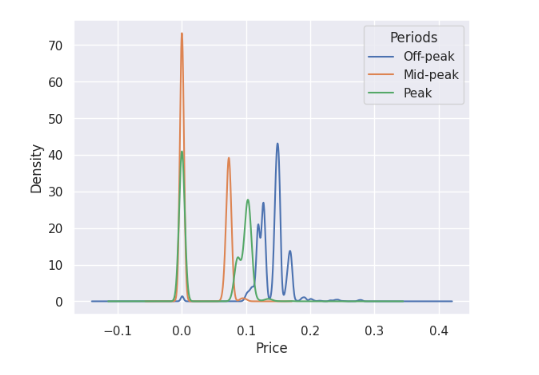

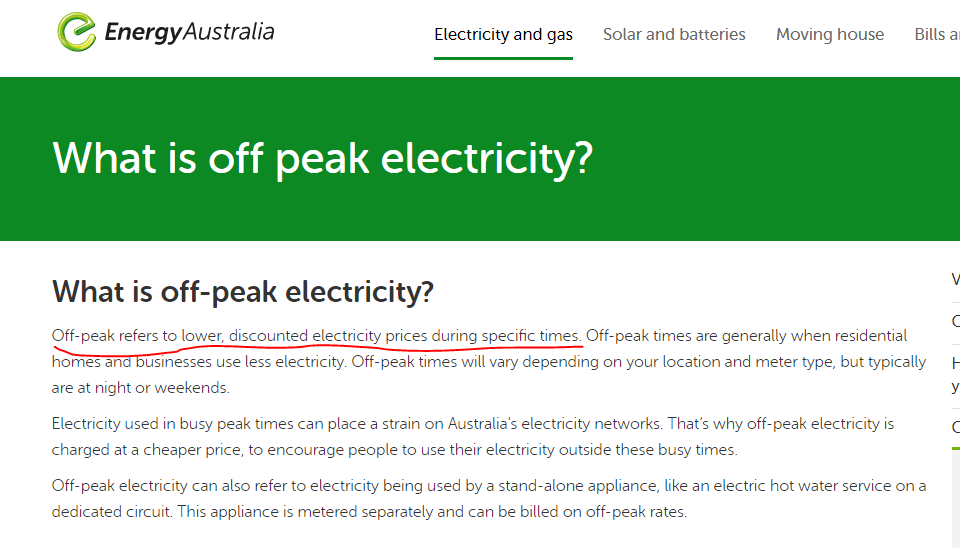



In [ ]:
--
# Load the client_data.csv file
client_data = pd.read_csv('/kaggle/input/bcg-intership-files/client_data.csv')

# Load the price_data.csv file
price_data = pd.read_csv('/kaggle/input/bcg-intership-files/price_data.csv')

# Merge the two datasets on the 'id' column
merged_data = pd.merge(client_data, price_data, on='id', how='inner')

# Select relevant columns
relevant_columns = ['id', 'has_gas', 'cons_last_month', 'forecast_cons_12m',
                    'forecast_cons_year', 'forecast_discount_energy', 'forecast_meter_rent_12m',
                    'forecast_price_energy_off_peak', 'forecast_price_energy_peak',
                    'forecast_price_pow_off_peak', 'num_years_antig',
                    'price_off_peak_var', 'price_peak_var', 'price_mid_peak_var',
                    'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix', 'churn']
data = merged_data[relevant_columns]

# Convert categorical variable 'has_gas' to binary
data['has_gas'] = data['has_gas'].map({'f': 0, 't': 1})

# Define a function to calculate the price elasticity of demand (PED) for each customer
def calculate_ped(row, reference_price):
    # Calculate the current price and demand
    current_price = row[['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var']].sum() + \
    row[['price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']].sum()
    
    current_demand = row['forecast_cons_12m']
    # Calculate the new price and demand after a price change
    new_price = reference_price
    new_demand = row['forecast_cons_12m'] * (1 - row['forecast_price_energy_off_peak'] * (new_price - current_price) / current_price)
    # Calculate the price elasticity of demand
    ped = (new_demand - current_demand) / current_demand / (new_price - current_price) * current_price / current_demand
    return ped

'''Define a function to calculate the price sensitivity of churn for a given reference price'''
def calculate_sensitivity(reference_price):
    '''# Calculate the PED for each customer'''
    data['ped'] = data.apply(lambda row: calculate_ped(row, reference_price), axis=1)
    '''# Calculate the average PED and churn rate for each PED bin'''
    ped_bins = pd.cut(data['ped'], bins=[-np.inf, -2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0, np.inf], include_lowest=True)
    ped_bins_data = data.groupby(ped_bins).agg({'ped': 'mean', 'churn': 'mean', 'id': 'count'})
    '''# Plot the sensitivity curve'''
    plt.plot(ped_bins_data['ped'], ped_bins_data['churn'], label=f"Price = {reference_price}")
    plt.xlabel("Price Elasticity of Demand")
    plt.ylabel("Churn Rate")
    plt.legend()

'''# Calculate the sensitivity curve for different reference prices'''
reference_prices = [100, 80, 60, 40, 20]
for i in reference_prices:
    calculate_sensitivity(i)

plt.show()


### Statistics

Now let's look at some statistics about the datasets. We can do this by using the `describe()` method.

---

## Data visualization

If you're working in Python, two of the most popular packages for visualization are `matplotlib` and `seaborn`. We highly recommend you use these, or at least be familiar with them because they are ubiquitous!

Below are some functions that you can use to get started with visualizations. 

def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    """
    ax = dataframe.plot(kind="bar",stacked=True,figsize=size_,rot=rot_,title=title_)

    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)
    # Rename legend
    plt.legend(["Retention", "Churn"], loc=legend_)
    # Labels
    plt.ylabel("Company base (%)")
    plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
    """
    Add value annotations to the bars
    """

    # Iterate over the plotted rectanges/bars
    for p in ax.patches:
        
        # Calculate annotation
        value = str(round(p.get_height(),1))
        # If value is 0 do not annotate
        if value == '0.0':
            continue
        ax.annotate(
            value,
            ((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
            color=colour,
            size=textsize
        )

def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distirbution in a stacked histogram of churned or retained company
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"Retention": dataframe[dataframe["churn"]==0][column],
    "Churn":dataframe[dataframe["churn"]==1][column]})
    # Plot the histogram
    temp[["Retention","Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')

Thhe first function `plot_stacked_bars` is used to plot a stacked bar chart. An example of how you could use this is shown below:

In [ ]:
churn = client[['id', 'churn']]
churn.columns = ['Companies', 'churn']
churn_total = churn.groupby(churn['churn']).count()
churn_percentage = churn_total / churn_total.sum() * 100
plot_stacked_bars(churn_percentage.transpose(), "Churning status", (5, 5), legend_="lower right")

The second function `annotate_bars` is used by the first function, but the third function `plot_distribution` helps you to plot the distribution of a numeric column. An example of how it can be used is given below:

In [ ]:
consumption = client[['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'imp_cons', 'has_gas', 'churn']]

fig, axs = plt.subplots(nrows=1, figsize=(18, 5))

plot_distribution(consumption, 'cons_12m', axs)